<a href="https://colab.research.google.com/github/naserjawas/TorchUp/blob/main/TorchUp_LabKC_Sesi2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TorchUp Sesi 2

**Materi:**
1. Membuat Model
2. Training
3. Testing

## Import pustaka

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

## Load Data

### Normalise function

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### Load dataset

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(
    root = './data',
    train = True,
    download = True,
    transform = transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root = './data',
    train = False,
    download = True,
    transform = transform
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 305kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.61MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.4MB/s]


### Membuat Dataloader

In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size=64,
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=64,
                         shuffle=False)

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


## Membuat Model

In [ ]:
from torch.nn.modules import Conv2d
from torch.nn.modules.pooling import MaxPool2d
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #28x28 -> 14x14

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #14x14 -> 7x7
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*7*7, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

Setiap layer menghasilkan ouput dengan ukuran tensor sebagai berikut:

| Layer |   Output   |
| --- | --- |
|input  | 1 x 28 x 28|
|Conv1  |16 x 28 x 28|
|MaxPool|16 x 14 x 14|
|Conv2  |32 x 14 x 14|
|MaxPool|32 x  7 x  7|
|Flatten|1568        |

## Inisiasi Komponen Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan Device: {device}")

model = SimpleCNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Menggunakan Device: cuda


## Training

In [ ]:
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 0.4801
Epoch 2/5, Loss: 0.3131
Epoch 3/5, Loss: 0.2650
Epoch 4/5, Loss: 0.2359
Epoch 5/5, Loss: 0.2136


## Testing

In [ ]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 90.50%


# Contoh dengan Dataset Custom

Download dataset dari link berikut ini: [Pima Indians Diabetes](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

In [ ]:
!curl -L -o ./pima-indians-diabetes-database.zip https://www.kaggle.com/api/v1/datasets/download/uciml/pima-indians-diabetes-database

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  9128  100  9128    0     0  20946      0 --:--:-- --:--:-- --:--:-- 20946


In [ ]:
!unzip ./pima-indians-diabetes-database.zip -d ./data

Archive:  ./pima-indians-diabetes-database.zip
  inflating: ./data/diabetes.csv     


## Import Pustaka

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler

## Load Data

### Membuat Class Dataset

In [ ]:
class PimaDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)

        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values

        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = PimaDataset('./data/diabetes.csv')
print(f"Dataset size: {len(dataset)}")
print(f"Feature shape: {dataset[0][0].shape}")
print(f"Label: {dataset[0][1]}")


### Split Dataloader

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


for X_batch, y_batch in train_loader:
    print(f"X batch shape: {X_batch.shape}")
    print(f"y batch shape: {y_batch.shape}")
    break

## Membuat Model

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size):
        super(SimpleMLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=16),
            nn.ReLU(),

            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),

            nn.Linear(in_features=8, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

## Inisiasi Komponen Training

In [ ]:
model = SimpleMLP(input_size=8)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Training

In [ ]:
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for X_batch, y_batch in train_loader:
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/100, Loss: 0.7047
Epoch 2/100, Loss: 0.7002
Epoch 3/100, Loss: 0.6986
Epoch 4/100, Loss: 0.6941
Epoch 5/100, Loss: 0.6917
Epoch 6/100, Loss: 0.6881
Epoch 7/100, Loss: 0.6857
Epoch 8/100, Loss: 0.6819
Epoch 9/100, Loss: 0.6783
Epoch 10/100, Loss: 0.6769
Epoch 11/100, Loss: 0.6730
Epoch 12/100, Loss: 0.6692
Epoch 13/100, Loss: 0.6667
Epoch 14/100, Loss: 0.6634
Epoch 15/100, Loss: 0.6584
Epoch 16/100, Loss: 0.6576
Epoch 17/100, Loss: 0.6558
Epoch 18/100, Loss: 0.6526
Epoch 19/100, Loss: 0.6486
Epoch 20/100, Loss: 0.6456
Epoch 21/100, Loss: 0.6462
Epoch 22/100, Loss: 0.6389
Epoch 23/100, Loss: 0.6375
Epoch 24/100, Loss: 0.6351
Epoch 25/100, Loss: 0.6325
Epoch 26/100, Loss: 0.6307
Epoch 27/100, Loss: 0.6221
Epoch 28/100, Loss: 0.6244
Epoch 29/100, Loss: 0.6182
Epoch 30/100, Loss: 0.6173
Epoch 31/100, Loss: 0.6149
Epoch 32/100, Loss: 0.6147
Epoch 33/100, Loss: 0.6078
Epoch 34/100, Loss: 0.6050
Epoch 35/100, Loss: 0.6005
Epoch 36/100, Loss: 0.6045
Epoch 37/100, Loss: 0.5987
Epoch 38/1

## Testing

In [ ]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        predicted = (outputs > 0.5).float()

        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 74.68%


# Latihan


Gunakan dataset breast cancer wisconsin data dari link berikut: [breast cancer wisconsin](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)

In [ ]:
!curl -L -o ./breast-cancer-wisconsin-data.zip https://www.kaggle.com/api/v1/datasets/download/uciml/breast-cancer-wisconsin-data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 49796  100 49796    0     0  35503      0  0:00:01  0:00:01 --:--:--  756k


In [ ]:
!unzip ./breast-cancer-wisconsin-data.zip -d ./data

Archive:  ./breast-cancer-wisconsin-data.zip
  inflating: ./data/data.csv         


Pada dataset ini kolom nomor 1 adalah `id` dan kolom nomor 2 adalah `diagnosis` yang merupakan kategori / label yang terdiri dari 2 kelas, yaitu: 'M' dan 'B'. Gunakan perintah berikut untuk memformat menjadi nilai angka dan juga mendapatkan data feature dan label.

In [ ]:
import pandas as pd

df = pd.read_csv('./data/data.csv')

df.iloc[:, 1] = df.iloc[:, 1].map({"M": 0, "B": 1})

X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

0


Silahkan diadaptasi dengan contoh MLP yang diberikan sebelumnya.

# Menggambar Network

In [ ]:
!pip install torchview

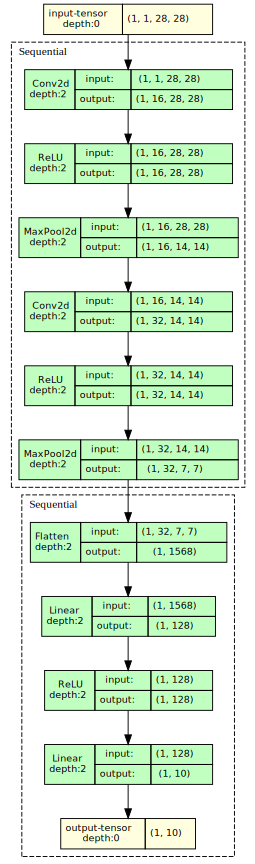

In [ ]:
from torchview import draw_graph

graph = draw_graph(model,
                   input_data = torch.randn(1, 1, 28, 28),
                   expand_nested=True,
                   save_graph=True,
                   filename="simplecnn",
                   )
graph.visual_graph
